# Read Gamma + Muon Simulations and Fit to Lab Data + Smear (vz5)
#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

This notebook imports the Geant4 simulated gamma + muon backgrounds and then applies a normal distribution transformation to the data in order to "smear" it so that it matches lab data. Chi2/NDF is calculated at the end.

The work is continued in Gamma_Normalization_vz1_Din

### Import needed libraries

In [1]:
import numpy as np

import ROOT
from ROOT import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
import scipy
import pandas as pd
import seaborn as sns

from datetime import datetime
from glob import glob

%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import gamma_normalize
import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02
/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


### Declare constants

In [2]:
ped = 50 #pedestal correction

# Declare constants for conversion from ADC to PE/MeV

adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

### Import Simulated .ROOT Files

In [3]:
folder_g = "/home/dt592/Geant4Work/gamma_sim/gamma_sim-build/" # location of the gamma sim build folder
folder_m = "/home/dt592/Geant4Work/muons_edited/muonsInPanel_build/" # location of the muon sim build folder
 
# Open ROOT files
f1460 = TFile.Open(folder_g + "K40-1460KeV-25x.root","READ")
f2614 = TFile.Open(folder_g + "Tl208-2614KeV-25x.root","READ")

# Bismuth peaks
f1120 = TFile.Open(folder_g + "Bi214-1120KeV-25x.root", "READ")
f1238 = TFile.Open(folder_g + "Bi214-1238KeV-25x.root", "READ")
f1764 = TFile.Open(folder_g + "Bi214-1764KeV-25x.root", "READ")
f2204 = TFile.Open(folder_g + "Bi214-2204KeV-25x.root", "READ")

# Lower peaks
f968 = TFile.Open(folder_g + "Ac228-968KeV-25x.root", "READ")
f934 = TFile.Open(folder_g + "Bi214-934KeV-25x.root", "READ")
f911 = TFile.Open(folder_g + "Ac228-911KeV-25x.root", "READ")
f609 = TFile.Open(folder_g + "Bi214-609KeV-25x.root", "READ")
f583 = TFile.Open(folder_g + "Tl208-583KeV-25x.root", "READ")

# Muons
muons = TFile(folder_m + "muonsJ_normalized.root", "READ")

## 

# Read the TTree for main two gamma isotopes
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# Read the TTree for the nearby Bismuth-214 isotopes
tree1120 = f1120.Get("Hits")
tree1238 = f1238.Get("Hits")
tree1764 = f1764.Get("Hits")
tree2204 = f2204.Get("Hits")

# Read the TTree for the remaining low-freq. isotopes
tree968 = f968.Get("Hits")
tree934 = f934.Get("Hits")
tree911 = f911.Get("Hits")
tree609 = f609.Get("Hits")
tree583 = f583.Get("Hits")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

In [4]:
# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)

energyDeposited1120 = []
entries= tree1120.GetEntries();
for i in range(0,entries):
    tree1120.GetEntry(i)
    energyDeposited1120.append(tree1120.EnergyDeposited)

energyDeposited1238 = []
entries= tree1238.GetEntries();
for i in range(0,entries):
    tree1238.GetEntry(i)
    energyDeposited1238.append(tree1238.EnergyDeposited)

energyDeposited1764 = []
entries= tree1764.GetEntries();
for i in range(0,entries):
    tree1764.GetEntry(i)
    energyDeposited1764.append(tree1764.EnergyDeposited)

energyDeposited2204 = []
entries= tree2204.GetEntries();
for i in range(0,entries):
    tree2204.GetEntry(i)
    energyDeposited2204.append(tree2204.EnergyDeposited)
    
# And the remaining peaks
energyDeposited968 = []
entries= tree968.GetEntries();
for i in range(0,entries):
    tree968.GetEntry(i)
    energyDeposited968.append(tree968.EnergyDeposited)

energyDeposited934 = []
entries= tree934.GetEntries();
for i in range(0,entries):
    tree934.GetEntry(i)
    energyDeposited934.append(tree934.EnergyDeposited)

energyDeposited911 = []
entries= tree911.GetEntries();
for i in range(0,entries):
    tree911.GetEntry(i)
    energyDeposited911.append(tree911.EnergyDeposited)

energyDeposited609 = []
entries= tree609.GetEntries();
for i in range(0,entries):
    tree609.GetEntry(i)
    energyDeposited609.append(tree609.EnergyDeposited)

energyDeposited583 = []
entries= tree583.GetEntries();
for i in range(0,entries):
    tree583.GetEntry(i)
    energyDeposited583.append(tree583.EnergyDeposited)
    
# Append muons
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)

In [5]:
# Concatenate the energies into np arrays
g_mev = np.concatenate((energyDeposited1460,energyDeposited2614,energyDeposited1120,energyDeposited1238,energyDeposited1764,energyDeposited2204,energyDeposited968,energyDeposited934,energyDeposited911,energyDeposited609,energyDeposited583)) # gamma 
mu_mev = np.array(muonsEnergy) # muons
sim_mev = np.concatenate((g_mev, mu_mev)) # total

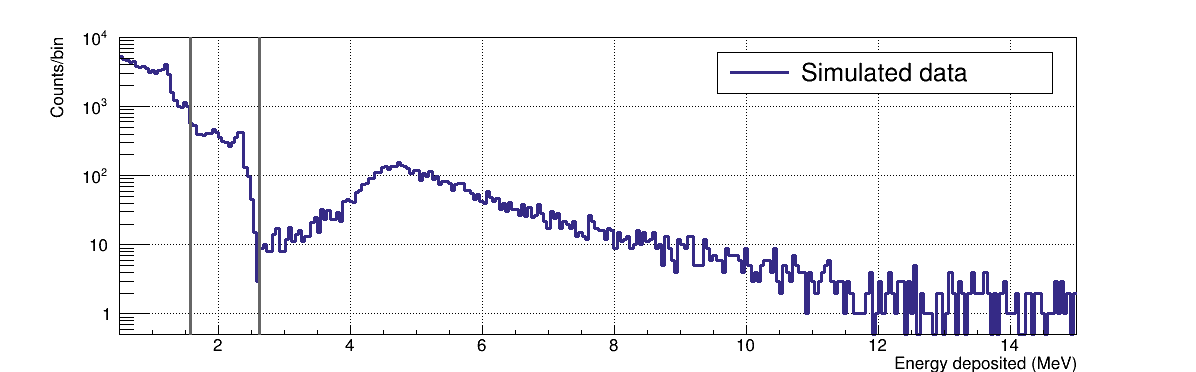

In [6]:
c1 = TCanvas('c1','',1200,400)
sim_root = TH1D('sim_root','',300,0.5,15)
fill_hist(sim_root, sim_mev)
gStyle.SetPalette(kBird)

sim_root.Draw("plc pmc")
sim_root.GetXaxis().SetTitle("Energy deposited (MeV)")
sim_root.GetXaxis().SetLabelSize(.05)
sim_root.GetXaxis().SetTitleSize(.05)
sim_root.GetYaxis().SetTitle("Counts/bin")
sim_root.GetYaxis().SetLabelSize(.05)
sim_root.GetYaxis().SetTitleSize(.05)
sim_root.GetYaxis().SetTitleOffset(.65)
sim_root.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)

legend = TLegend(0.6,0.75,0.88,0.86)
legend.AddEntry(sim_root,"Simulated data","l")
legend.Draw()

line1 = TLine(1.57,0,1.57,10**4)
line1.SetLineColor(ROOT.kGray+2)
line1.SetLineWidth(3)
line1.Draw()

line2 = TLine(2.614,0,2.614,10**4)
line2.SetLineColor(ROOT.kGray+2)
line2.SetLineWidth(3)
line2.Draw()

c1.Draw()

### Load and read lab data from directory

In [7]:
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


In [8]:
# Convert lab data to MeV

d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV

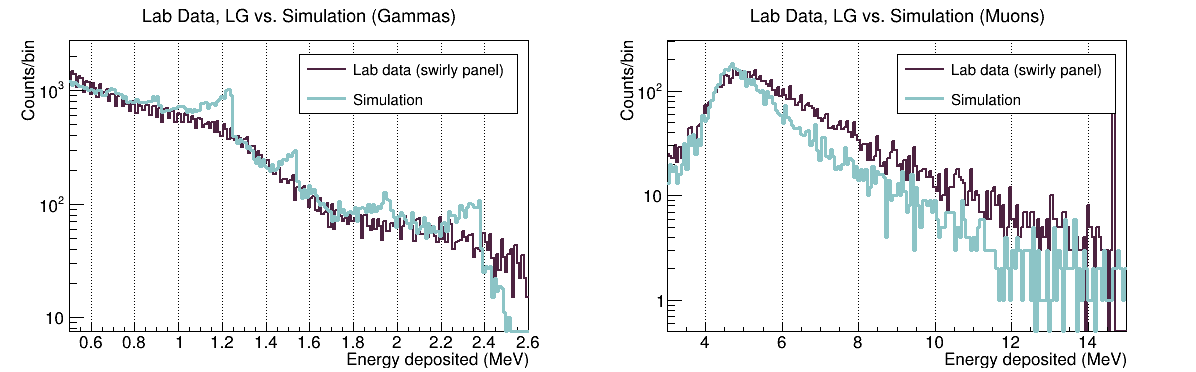

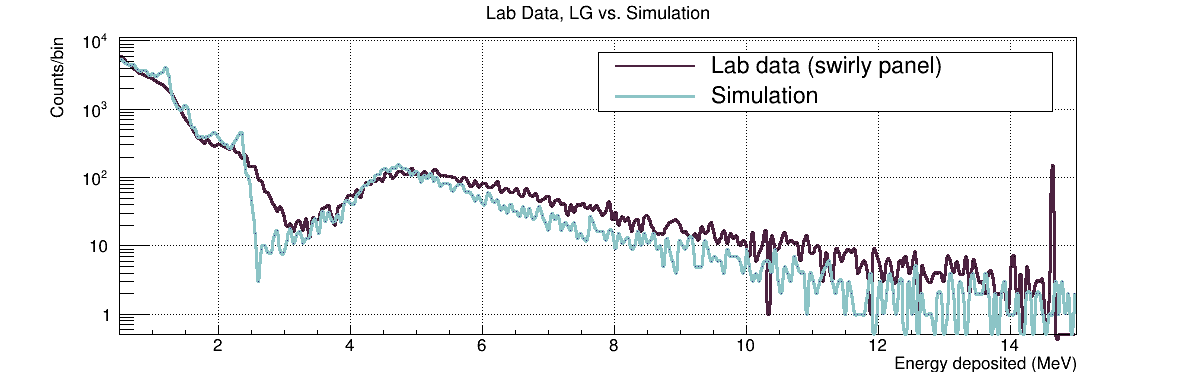

In [9]:
c2_1 = TCanvas('c2_1','',1200,400)
c2_1.cd()

lab_root = TH1D('lab_root','',300,0.5,15)
fill_hist(lab_root, lab_mev)
gStyle.SetPalette(kCandy)

lab_g = TH1D('lab_g','',200,0.5,2.6)
fill_hist(lab_g, lab_mev)
lab_mu = TH1D('lab_mu','',200,3,15)
fill_hist(lab_mu, lab_mev)
sim_g = TH1D('sim_g','',200,0.5,2.6)
fill_hist(sim_g, g_mev)
sim_mu = TH1D('sim_mu','',200,3,15)
fill_hist(sim_mu, mu_mev)

c2_1.Divide(2,0)

c2_1.cd(1)

lab_g.Draw("plc pmc")
lab_g.SetTitle("Lab Data, LG vs. Simulation (Gammas)")
lab_g.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_g.GetXaxis().SetLabelSize(.05)
lab_g.GetXaxis().SetTitleSize(.05)
lab_g.GetYaxis().SetTitle("Counts/bin")
lab_g.GetYaxis().SetLabelSize(.05)
lab_g.GetYaxis().SetTitleSize(.05)
lab_g.GetYaxis().SetTitleOffset(.9)
lab_g.SetLineWidth(2)

sim_g.Draw("plc pmc same")
sim_g.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend = TLegend(0.5,0.7,0.88,0.86)
legend.AddEntry(lab_g,"Lab data (swirly panel)","l")
legend.AddEntry(sim_g,"Simulation","l")
legend.Draw()

c2_1.cd(2)

lab_mu.Draw("plc pmc")
lab_mu.SetTitle("Lab Data, LG vs. Simulation (Muons)")
lab_mu.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_mu.GetXaxis().SetLabelSize(.05)
lab_mu.GetXaxis().SetTitleSize(.05)
lab_mu.GetYaxis().SetTitle("Counts/bin")
lab_mu.GetYaxis().SetLabelSize(.05)
lab_mu.GetYaxis().SetTitleSize(.05)
lab_mu.GetYaxis().SetTitleOffset(.9)
lab_mu.SetLineWidth(2)

sim_mu.Draw("plc pmc same")
sim_mu.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend2 = TLegend(0.5,0.7,0.88,0.86)
legend2.AddEntry(lab_g,"Lab data (swirly panel)","l")
legend2.AddEntry(sim_g,"Simulation","l")
legend2.Draw()

c2_2 = TCanvas('c2_2','',1200,400)
c2_2.cd()
gStyle.SetPalette(ROOT.kCandy)

lab_root.Draw("plc pcm")
lab_root.SetTitle("Lab Data, LG vs. Simulation")
lab_root.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_root.GetXaxis().SetLabelSize(.05)
lab_root.GetXaxis().SetTitleSize(.05)
lab_root.GetYaxis().SetTitle("Counts/bin")
lab_root.GetYaxis().SetLabelSize(.05)
lab_root.GetYaxis().SetTitleSize(.05)
lab_root.GetYaxis().SetTitleOffset(.65)
lab_root.SetLineWidth(3)

sim_root.Draw("plc pcm same")
sim_root.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)

legend3 = TLegend(0.5,0.7,0.88,0.86)
legend3.AddEntry(lab_g,"Lab data (swirly panel)","l")
legend3.AddEntry(sim_g,"Simulation","l")
legend3.Draw()

c2_1.Draw()
c2_2.Draw()

# c2_1.SaveAs("NBv5_LabVsSimulation_v3_GammasAndMuons.png")
# c2_2.SaveAs("NBv5_LabVsSimulation_v3_FullSpectrum.png")

### Smearing first attempt (Constant sigma)

Using the sigma calculated from the gaussian Cs-137 fit, I applied smearing using the following function as a sort of “first pass.”

Because we are applying smearing in PE but the plot is in MeV, I am converting smearing to PE first when applying it, and then back to MeV for the plot, hence the *pe_mev multiplication.

Here is the first attempt with a “constant” smearing. Of course, smearing is not necessarily constant with energy, so for my second attempt I will try modeling it linearly and see what happens.

In [10]:
sim_pe = sim_mev * pe_mev
g_pe = g_mev * pe_mev
mu_pe = mu_mev * pe_mev

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.



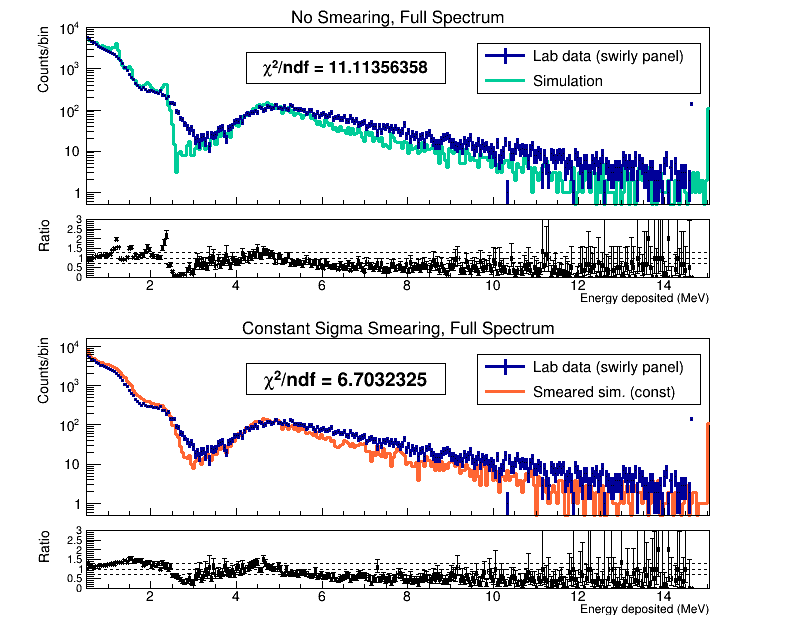

In [11]:
mugam_cut = 3 # separation between muon peak and gamma bg
lv = 3.8 * 10**3

#apply smearing
bg_smeared = np.random.normal(loc=sim_pe, scale = sigma_pe)

#turn this into a ROOT histogram
const_smear = TH1D('const_smear','',300,0.5,15)

#PLOT

c3 = TCanvas('c3','',800,650)
gStyle.SetPalette(kBird)
lab_root.SetLineColor(kBlue+2)
const_smear.Draw()
const_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
const_smear.GetXaxis().SetLabelSize(.05)
const_smear.GetXaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitle("Counts/bin")
const_smear.GetYaxis().SetLabelSize(.05)
const_smear.GetYaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitleOffset(.9)
const_smear.SetLineColor(kOrange+8)
const_smear.SetLineWidth(3)
fill_hist(const_smear,bg_smeared/pe_mev)

c3.Clear()

gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)
c3.Divide(0,2)

#

c3.cd(1)

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)
# sim_root.Draw("plc pmc")

rp1 = ROOT.TRatioPlot(sim_root,lab_root)
rp1.Draw("plc pmc")

sim_root.SetTitle("No Smearing, Full Spectrum")
sim_root.SetLineColor(kTeal - 1)

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)
# rp1.SetSplitFraction(0.4)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(sim_root.Chi2Test(lab_root, "CHI2/NDF"), 8)) + " "

#
c3.cd(2)

gPad.SetLogy()
gStyle.SetOptStat(0)

rp2 = TRatioPlot(const_smear,lab_root)
rp2.Draw()

const_smear.SetTitle("Constant Sigma Smearing, Full Spectrum")

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetLowerRefYaxis().SetTitleOffset(1.1)
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(0,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(const_smear.Chi2Test(lab_root, "CHI2/NDF"), 8)) + " "

c3.cd()

legend1 = TLegend(0.6,0.85,0.88,0.93)
legend1.AddEntry(lab_root,"Lab data (swirly panel)","le")
legend1.AddEntry(sim_root,"Simulation","l")
legend1.Draw()

title1 = TPaveText(.31,.865,.56,.915)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

legend2 = TLegend(0.6,0.35,0.88,0.43)
legend2.AddEntry(lab_root,"Lab data (swirly panel)","le")
legend2.AddEntry(const_smear,"Smeared sim. (const)","l")
legend2.Draw()

title2 = TPaveText(.31,.365,.56,.415)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c3.Draw()
# c3.SaveAs("NBv5_ConstSmearing_Full_v3.png")

### Smearing second attempt (linear sigma), comparison with const. sigma

Value of sigma at 1 MeV was extrapolated by assuming direct proprtionality scale of sigma per MeV. Then, This value of sigma was converted to PE and scaled with each of the bins in PE. 

Different smearing was applied to muons and gammas, with the former having a factor of 1.095 multiplying the distribution as this was found by eye to be good. 

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.



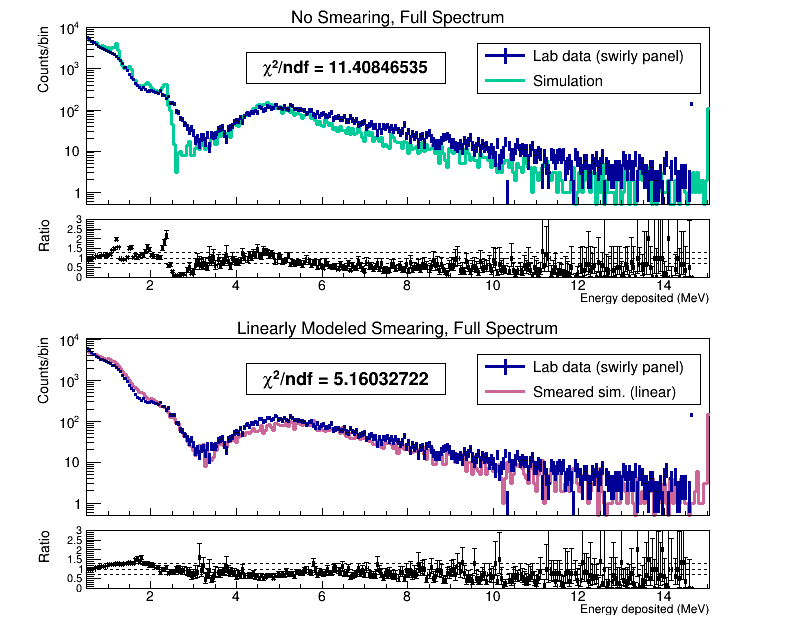

In [12]:
#apply smearing
bg_smeared_lin_g_pe = np.random.normal(loc=g_pe, scale = 0.01 * lin_sigma_pe * g_pe)
bg_smeared_lin_mu_pe = 1.095 * np.random.normal(loc=mu_pe, scale = 0.01 * lin_sigma_pe * mu_pe)
bg_smeared_lin_sim_pe = np.concatenate((bg_smeared_lin_g_pe, bg_smeared_lin_mu_pe))

#turn this into a ROOT histogram
lin_smear = TH1D('lin_smear','',300,0.5,15)

#PLOT

c4 = TCanvas('c4','',800,650)
lin_smear.Draw()
lin_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
lin_smear.GetXaxis().SetLabelSize(.05)
lin_smear.GetXaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitle("Counts/bin")
lin_smear.GetYaxis().SetLabelSize(.05)
lin_smear.GetYaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitleOffset(.9)
lin_smear.SetLineColor(kPink+2)
lin_smear.SetLineWidth(3)
fill_hist(lin_smear,bg_smeared_lin_sim_pe/pe_mev)

c4.Clear()

gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)
# lab_root.Draw("PLC PMC")
# sim_root.Draw("SAME PLC PMC")
# lin_smear.Draw("SAME PLC PMC")

# lab_root.SetLineColor(ROOT.kBird + 0)
sim_root.SetLineColor(kTeal - 1)
sim_root.SetLineWidth(3)
lab_root.SetLineWidth(3)
# lin_smear.SetLineColor(+ 2)

c4.Divide(0,2)

#

c4.cd(1)

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)

rp1 = TRatioPlot(sim_root,lab_root)
rp1.Draw()

sim_root.SetTitle("No Smearing, Full Spectrum")

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)
# rp1.SetSplitFraction(0.4)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(sim_root.Chi2Test(lab_root, "CHI2/NDF"), 8)) + " "

#
c4.cd(2)

gPad.SetLogy()
gStyle.SetOptStat(0)

rp2 = TRatioPlot(lin_smear,lab_root)
rp2.Draw()

lin_smear.SetTitle("Linearly Modeled Smearing, Full Spectrum")

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetLowerRefYaxis().SetTitleOffset(1.1)
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(0,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(lin_smear.Chi2Test(lab_root, "CHI2/NDF"), 8)) + " "

c4.cd()

legend1 = TLegend(0.6,0.85,0.88,0.93)
legend1.AddEntry(lab_root,"Lab data (swirly panel)","le")
legend1.AddEntry(sim_root,"Simulation","l")
legend1.Draw()

title1 = TPaveText(.31,.865,.56,.915)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

legend2 = TLegend(0.6,0.35,0.88,0.43)
legend2.AddEntry(lab_root,"Lab data (swirly panel)","le")
legend2.AddEntry(lin_smear,"Smeared sim. (linear)","l")
legend2.Draw()

title2 = TPaveText(.31,.365,.56,.415)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c4.Draw()
# c4.SaveAs("NBv5_LinSmearing_Full_v5.png")

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.



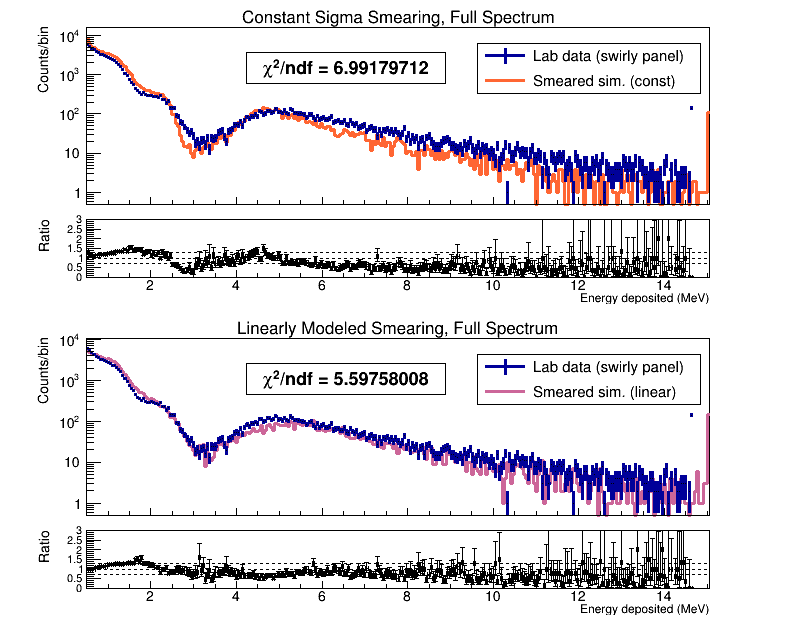

In [13]:
#PLOT

c5 = TCanvas('c5','',800,650)

gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)

c5.Divide(0,2)

#

c5.cd(1)

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)
const_smear.SetLineWidth(3)

rp1 = TRatioPlot(const_smear,lab_root)
rp1.Draw()

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(const_smear.Chi2Test(lab_root, "CHI2/NDF"), 8)) + " "

#
c5.cd(2)

gPad.SetLogy()
gStyle.SetOptStat(0)

rp2 = TRatioPlot(lin_smear,lab_root)
rp2.Draw()

lin_smear.SetTitle("Linearly Modeled Smearing, Full Spectrum")

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetLowerRefYaxis().SetTitleOffset(1.1)
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(0,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(lin_smear.Chi2Test(lab_root, "CHI2/NDF"), 8)) + " "

c5.cd()

legend1 = TLegend(0.6,0.85,0.88,0.93)
legend1.AddEntry(lab_root,"Lab data (swirly panel)","le")
legend1.AddEntry(const_smear,"Smeared sim. (const)","l")
legend1.Draw()

title1 = TPaveText(.31,.865,.56,.915)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

legend2 = TLegend(0.6,0.35,0.88,0.43)
legend2.AddEntry(lab_root,"Lab data (swirly panel)","le")
legend2.AddEntry(lin_smear,"Smeared sim. (linear)","l")
legend2.Draw()

title2 = TPaveText(.31,.365,.56,.415)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c5.Draw()
# c5.SaveAs("NBv5_LinConstSmearing_Full_v2.png")

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Warning in <TFile::Append>: Replacing existing TH1: lab_g (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: lab_mu (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 4 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 9 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 1 event.



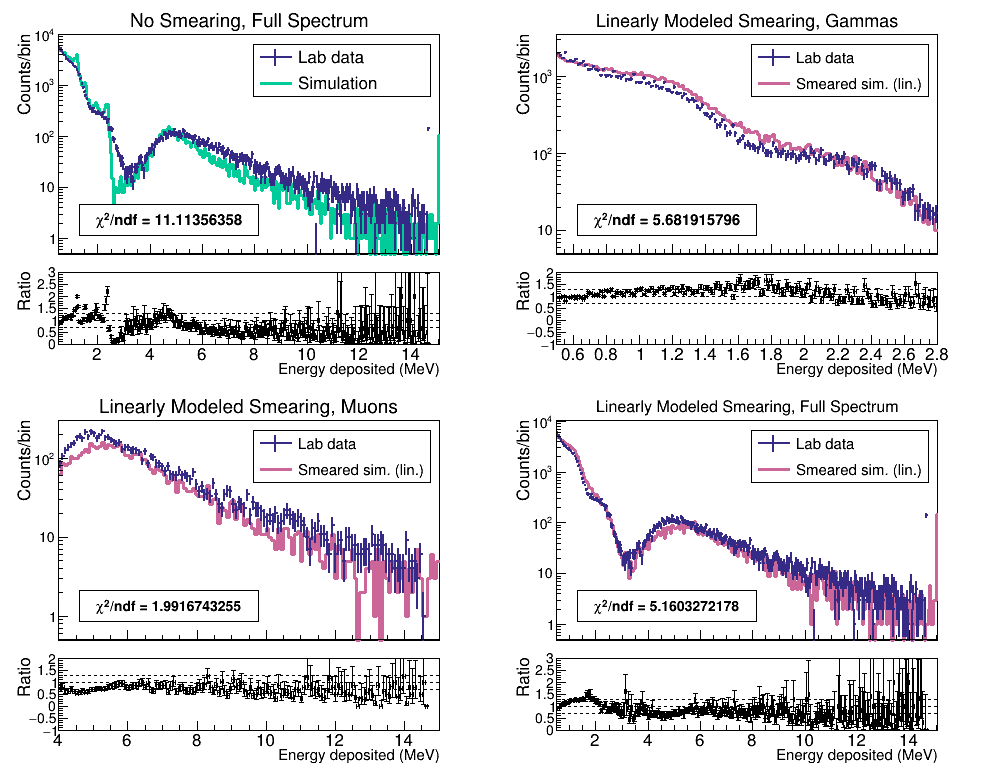

In [14]:
# Try this
c6 = TCanvas('c6',"",1000,800)
gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)
c6.Divide(2,2)

#

c6.cd(1)
gStyle.SetTitleFontSize(0.075)
gStyle.SetPalette(ROOT.kBird)

lab_th = TH1D('No Smearing, Full Spectrum','No Smearing, Full Spectrum',300,0.5,15)
fill_hist(lab_th,lab_mev)
lab_th.Draw("plc pmc")
lab_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_th.SetLineWidth(2)

lab_sim_th = TH1D('Simulation (No Smearing)','No Smearing, Full Spectrum',300,0.5,15)
fill_hist(lab_sim_th,sim_mev)
lab_sim_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_sim_th.SetLineColor(kTeal - 1)
lab_sim_th.SetLineWidth(3)

rp1 = ROOT.TRatioPlot(lab_sim_th,lab_th)

gPad.SetLogy()
gStyle.SetOptStat(2)
rp1.Draw()

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetLowerRefYaxis().SetTitleOffset(0.9)
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.9)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetUpperRefYaxis().SetLabelSize(.04)
rp1.GetUpperRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)


chi2_1 = " #chi^{2}/ndf = " + str(round(lab_sim_th.Chi2Test(lab_th, "CHI2/NDF"), 8)) + " "

legend1 = TLegend(0.51,0.76,0.88,0.90)
legend1.AddEntry(lab_th,"Lab data","le")
legend1.AddEntry(lab_sim_th,"Simulation","l")
legend1.Draw()

#

c6.cd(2)
gStyle.SetTitleFontSize(0.075)
gStyle.SetPalette(ROOT.kBird)

lab_g_th = TH1D('lab_g', 'Smeared Simulation (Linear), Gammas', 150, 0.5, 2.8)
smeared_lin_g_th = TH1D('smeared1', 'Linearly Modeled Smearing, Gammas', 150, 0.5, 2.8)
fill_hist(lab_g_th, lab_mev)
fill_hist(smeared_lin_g_th, bg_smeared_lin_g_pe/pe_mev)

lab_g_th.Draw("plc pmc")
lab_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_g_th.SetLineWidth(2)

smeared_lin_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_g_th.SetLineColor(ROOT.kPink + 2)
smeared_lin_g_th.SetLineWidth(3)

rp2 = TRatioPlot(smeared_lin_g_th,lab_g_th)

gStyle.SetOptStat(0)
gPad.SetLogy()

rp2.Draw()

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetLowerRefYaxis().SetTitleOffset(.9)
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(.9)
rp2.GetLowerRefYaxis().SetRangeUser(-1,2)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetUpperRefYaxis().SetLabelSize(.04)
rp2.GetUpperRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(smeared_lin_g_th.Chi2Test(lab_g_th, "CHI2/NDF"), 9)) + " "

legend2 = TLegend(0.51,0.76,0.88,0.90)
legend2.AddEntry(lab_th,"Lab data","le")
legend2.AddEntry(smeared_lin_g_th,"Smeared sim. (lin.)","l")
legend2.Draw()

#

c6.cd(3)
gStyle.SetTitleFontSize(0.075)
gStyle.SetPalette(ROOT.kBird)

lab_mu_th = TH1D('lab_mu', 'Smeared Simulation (Linear), Muons', 134, 4, 15)
fill_hist(lab_mu_th, lab_mev)
smeared_lin_mu_th = ROOT.TH1D('smeared2', 'Linearly Modeled Smearing, Muons', 134, 4, 15)
fill_hist(smeared_lin_mu_th, bg_smeared_lin_mu_pe/pe_mev)

lab_mu_th.Draw("plc pmc")
lab_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_mu_th.SetLineWidth(2)

smeared_lin_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_mu_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_mu_th.SetLineColor(ROOT.kPink + 2)
smeared_lin_mu_th.SetLineWidth(3)

rp3 = TRatioPlot(smeared_lin_mu_th,lab_mu_th)

gPad.SetLogy()
gStyle.SetOptStat(0)

rp3.Draw()
rp3.GetLowerRefYaxis().SetTitle("Ratio")
rp3.GetLowerRefYaxis().SetTitleOffset(.9)
rp3.GetUpperRefYaxis().SetTitle("Counts/bin")
rp3.GetUpperRefYaxis().SetTitleOffset(.9)
rp3.GetLowerRefYaxis().SetRangeUser(-1,2)

rp3.GetLowerRefYaxis().SetLabelSize(.04)
rp3.GetLowerRefYaxis().SetTitleSize(.05)
rp3.GetUpperRefYaxis().SetLabelSize(.04)
rp3.GetUpperRefYaxis().SetTitleSize(.05)
rp3.GetLowerRefXaxis().SetLabelSize(.05)
rp3.GetLowerRefXaxis().SetTitleSize(.045)

chi2_3 = " #chi^{2}/ndf = " + str(round(smeared_lin_mu_th.Chi2Test(lab_mu_th, "CHI2/NDF"), 10)) + " "

legend3 = TLegend(0.51,0.76,0.88,0.90)
legend3.AddEntry(lab_th,"Lab data","le")
legend3.AddEntry(smeared_lin_mu_th,"Smeared sim. (lin.)","l")
legend3.Draw()

#

c6.cd(4)
gStyle.SetPalette(ROOT.kBird)
gStyle.SetTitleFontSize(0.075)
lab_2_th = TH1D('lab_2', 'Smeared Simulation (Linear), Full Spectrum', 300, 0.5, 15)
fill_hist(lab_2_th, lab_mev)
smeared_lin_full_th = TH1D('smeared3', 'Linearly Modeled Smearing, Full Spectrum', 300, 0.5, 15)
fill_hist(smeared_lin_full_th, bg_smeared_lin_sim_pe/pe_mev)

lab_2_th.Draw("plc pmc")
lab_2_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_2_th.GetYaxis().SetTitle("Counts/bin")
lab_2_th.SetLineWidth(2)

smeared_lin_full_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_full_th.GetYaxis().SetTitle("Counts/bin")
smeared_lin_full_th.SetLineWidth(3)

smeared_lin_full_th.SetLineColor(ROOT.kPink + 2)

rp4 = TRatioPlot(smeared_lin_full_th,lab_2_th)

gPad.SetLogy()
gStyle.SetOptStat(0)

rp4.Draw()

rp4.GetLowerRefYaxis().SetTitle("Ratio")
rp4.GetLowerRefYaxis().SetTitleOffset(.9)
rp4.GetUpperRefYaxis().SetTitle("Counts/bin")
rp4.GetUpperRefYaxis().SetTitleOffset(.9)
rp4.GetLowerRefYaxis().SetRangeUser(0,3)

rp4.GetLowerRefYaxis().SetLabelSize(.04)
rp4.GetLowerRefYaxis().SetTitleSize(.05)
rp4.GetUpperRefYaxis().SetLabelSize(.04)
rp4.GetUpperRefYaxis().SetTitleSize(.05)
rp4.GetLowerRefXaxis().SetLabelSize(.05)
rp4.GetLowerRefXaxis().SetTitleSize(.045)

chi2_4 = " #chi^{2}/ndf = " + str(round(smeared_lin_full_th.Chi2Test(lab_2_th, "CHI2/NDF"), 10)) + " "

legend4 = TLegend(0.51,0.76,0.88,0.90)
legend4.AddEntry(lab_th,"Lab data","le")
legend4.AddEntry(smeared_lin_full_th,"Smeared sim. (lin.)","l")
legend4.Draw()

c6.cd()

title1 = TPaveText(.08,.695,.26,.735)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

title2 = TPaveText(.58,.695,.76,.735)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

title3 = TPaveText(.08,.195,.26,.235)
title3.AddText(chi2_3)
title3.SetMargin(0.05)
title3.SetBorderSize(1)
title3.SetFillColor(0)
title3.Draw()

title4 = TPaveText(.58,.195,.76,.235)
title4.AddText(chi2_4)
title4.SetMargin(0.05)
title4.SetBorderSize(1)
title4.SetFillColor(0)
title4.Draw()

c6.Draw()
# c6.SaveAs("NBv5_LinSmearing_CHI2NDF_v3.png")

### Import Notebook with Normalized Gammas, Concatenate Muon Flux

In [15]:
%%capture

%run /home/dt592/Geant4Work/Gamma_Normalization_Din_vz1.ipynb

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 5 points have been skipped
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



In [16]:
fill_hist(tots, bg_smeared_lin_mu_pe/pe_mev) # ONLY RUN THIS ONCE

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c7
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 5 points have been skipped
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TCanvas::Print>: png file NBv5_NORMALIZED_LinSmear_FullSpec_v2.png has been created


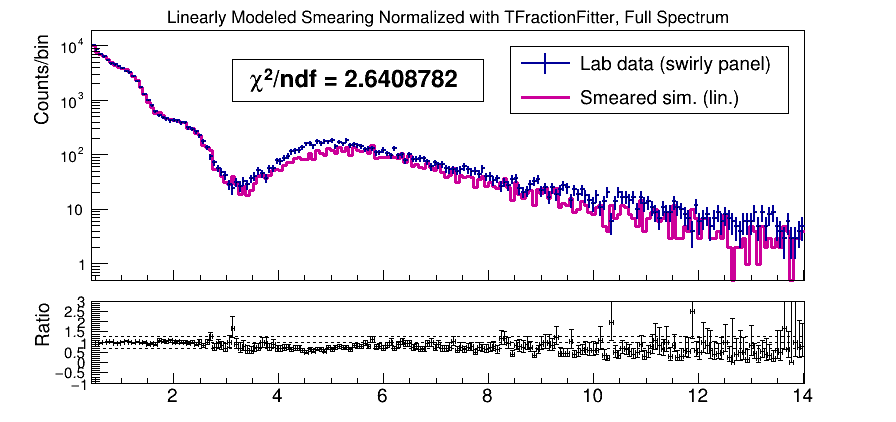

In [42]:
c7 = TCanvas('c7','',900,450)

# gStyle.SetPalette(kRust)
gPad.SetLogy()
gStyle.SetStatFontSize(.08)
gStyle.SetTitleFontSize(0.085)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)

h_dat.Draw("plc pmc hist")
tots.SetTitle("Linearly Modeled Smearing Normalized with TFractionFitter, Full Spectrum")

# tot.SetMarkerColor(kGray+1)
# tot.SetLineColor(kGray+1)
tots.SetLineWidth(3)
tots.SetLineColor(kTeal - 1)
tots.Draw("hist same")
tots.SetAxisRange(0.5, 14, "X")
h_dat.SetAxisRange(0.5, 14, "X")
tots.SetLineColor(kPink+8)
h_dat.SetLineWidth(2)

c7.Clear()

rp = TRatioPlot(tots,h_dat)
rp.Draw()

rp.GetLowerRefYaxis().SetTitle("Ratio")
rp.GetUpperRefYaxis().SetTitle("Counts/bin")
rp.GetUpperRefYaxis().SetTitleOffset(0.7)
rp.GetLowerRefYaxis().SetTitleOffset(0.7)
rp.GetLowerRefYaxis().SetRangeUser(-1,3)

rp.GetLowerRefYaxis().SetLabelSize(.04)
rp.GetLowerRefYaxis().SetTitleSize(.05)
rp.GetUpperRefYaxis().SetLabelSize(.04)
rp.GetUpperRefYaxis().SetTitleSize(.05)
rp.GetLowerRefXaxis().SetLabelSize(.05)
rp.GetLowerRefXaxis().SetTitleSize(.045)

# rp1.GetUpperPad().SetGrid()

chi2 = " #chi^{2}/ndf = " + str(round(tots.Chi2Test(h_dat, "CHI2/NDF"), 8)) + " "

legend = TLegend(0.57,0.73,0.88,0.89)
legend.AddEntry(h_dat,"Lab data (swirly panel)","le")
legend.AddEntry(tots,"Smeared sim. (lin.)","l")
legend.Draw()

title = TPaveText(0.26, 0.76, 0.54, 0.86, "NDC")
title.AddText(chi2)
title.SetMargin(0.05)
title.SetBorderSize(1)
title.SetFillColor(0)
title.Draw()

c7.Draw()

# c7.SaveAs("NBv5_NORMALIZED_LinSmear_FullSpec_v2.png")